## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd

from grr.cell_class import Cell
from grr.Trace import detectSpikes
from grr.Tools import stripNan
from grr.FrequencyInputCurve import FrequencyInputCurve
from ezephys.pltools import hide_border

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fI')

## Load data

First we'll just load the current step data.

In [4]:
DATA_PATH = os.path.join('data', 'raw', '5HT', 'current_steps')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
fnames

,Cell,R,C,hold,Steps
0,DRN159,707,43,-11.0,17n23013.abf
1,DRN160,365,79,-9.8,17n23017.abf
2,DRN162,485,57,-17.1,17n23022.abf
3,DRN163,1400,61,2.4,17n23027.abf
4,DRN164,919,39,-27.0,17n23034.abf
5,DRN165,759,63,-14.6,17n23038.abf
6,DRN196,923,74,-6.0,18111055.abf
7,DRN316,1200,40,-8.5,18420001.abf
8,DRN317,743,93,3.7,18420006.abf
9,DRN318,702,51,-8.0,18420025.abf


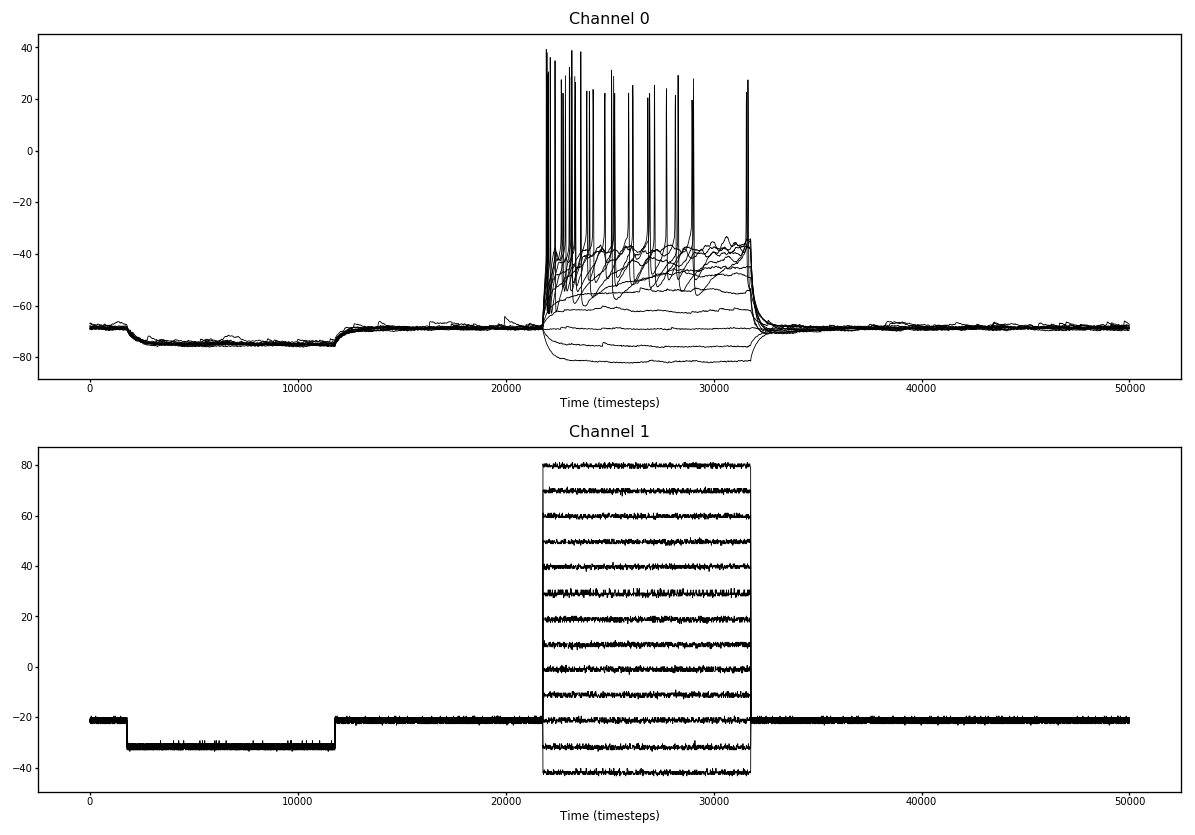

In [5]:
curr_steps = Cell().read_ABF([os.path.join(DATA_PATH, fn) for fn in fnames['Steps']])
curr_steps[0].plot()

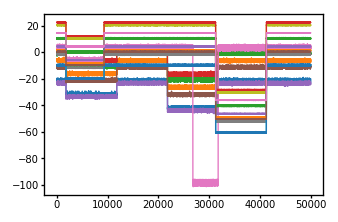

In [6]:
for expt in curr_steps:
    plt.plot(expt[1, :, 0])
plt.show()

Current step recordings have a similar structure, but differ in number of sweeps. Also possibly in spacing of current steps.

Automatically detect the start/end of the test pulse and current steps based on the first recording and then show whether this works for all cells.

In [7]:
change_threshold = 6. # pA threshold at which to detect a step.

tstpts = {'start': [], 'stop': []}
mainpts = {'start': [], 'stop': []}

for expt in curr_steps:
    try:
        falling = np.where(np.diff(expt[1, :, 0]) < -change_threshold)[0]
        tstpts['start'].append(falling[0])
        mainpts['start'].append(falling[1])
        
        rising = np.where(np.diff(expt[1, :, 0]) > change_threshold)[0]
        tstpts['stop'].append(rising[0])
        mainpts['stop'].append(rising[1])
    except ValueError:
        print 'Too many or too few steps detected. Might need to adjust `change_threshold`.'
        raise

del change_threshold

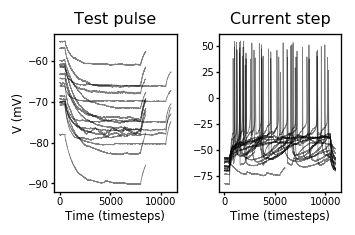

In [8]:
dt = 0.1 # ms. Assumed.

buffer_timesteps = 500

plt.figure()

tst_ax = plt.subplot(121)
tst_ax.set_title('Test pulse')

step_ax = plt.subplot(122)
step_ax.set_title('Current step')

for i, expt in enumerate(curr_steps):
    tst_ax.plot(
        expt[0, (tstpts['start'][i] - buffer_timesteps):(tstpts['stop'][i] + buffer_timesteps), :].mean(axis = 1), 
        'k-', lw = 0.5, alpha = 0.5
    )
    step_ax.plot(
        expt[0, (mainpts['start'][i] - buffer_timesteps):(mainpts['stop'][i] + buffer_timesteps), 8], 
        'k-', lw = 0.5, alpha = 0.5
    )
    
tst_ax.set_xlabel('Time (timesteps)')
tst_ax.set_ylabel('V (mV)')

step_ax.set_xlabel('Time (timesteps)')
step_ax.set_ylabel('')

plt.tight_layout()

plt.show()

In [9]:
qc_mask = []
for i, rec in enumerate(curr_steps):
    if (np.abs(rec[1, :, :] - np.mean(rec[1, :, :])) < 1.).all() :
        qc_mask.append(False)
        rec.plot()
    else:
        qc_mask.append(True)
        
curr_steps = [curr_steps[i] for i in range(len(curr_steps)) if qc_mask[i]]
print '{} of {} cells passed quality control.'.format(len(curr_steps), len(qc_mask))

del qc_mask

17 of 17 cells passed quality control.


## Generate f/I curves

f/I curves are usually rectified linear. However, in some cases non-monotonic f/I curves are observed, usually due to depolarization block.

In [10]:
# Detect spikes in all recordings.
spktimes = [detectSpikes(rec[0, :, :], 0., 3., 0, 0.1) for rec in curr_steps]

In [11]:
fi_summarizer = FrequencyInputCurve(lambda x_: np.all(np.nan_to_num(np.diff(x_) / x_[:-1]) > -0.25))

fi_data = {metric: [] for metric in fi_summarizer.summary_metrics}
fi_summaries = []

for i, (rec, times) in enumerate(zip(curr_steps, spktimes)):
    fi_summarizer.fit(times, rec[1, ...], (mainpts['start'][i], mainpts['stop'][i]), dt)
    
    fi_summaries.append(fi_summarizer.copy())
    
    for metric in fi_summarizer.summary_metrics:
        fi_data[metric].append(fi_summarizer.get_metric(metric))

fi_df = pd.DataFrame(fi_data)
fi_df.drop(columns=['CV', 'I', 'f'], inplace=True)
fi_df

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


,freq_at_50,freq_at_rheobase,gain,is_monotonic,rheobase,spearman_p,spearman_rho
0,4.039271,1.0,0.074977,True,8.766868,5.203924e-04,0.939827
1,0.540422,1.0,0.037190,True,54.663452,7.062569e-08,0.975217
2,0.010133,1.0,0.085683,True,60.045643,4.256164e-06,0.988024
3,0.000000,1.0,0.042441,True,64.524641,7.882961e-06,0.962950
4,4.242575,1.0,0.106712,True,16.735346,1.330989e-11,0.990100
5,0.029795,1.0,0.039304,True,59.471666,2.399471e-07,0.977008
6,2.000000,2.0,0.044860,True,44.279461,4.179468e-02,0.828079
7,5.000000,2.0,0.051668,True,8.477907,6.715554e-12,0.991170
8,1.826810,2.0,0.052506,True,50.878105,2.183923e-09,0.987686
9,2.884087,1.0,0.030544,True,30.874911,5.537728e-06,0.953463


In [12]:
fi_df.to_csv(os.path.join('data', 'processed', '5HT', 'current_steps_gain.csv'), index=False)

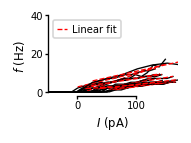

In [13]:
plt.figure(figsize=(1.5, 1))

first_fit = True
curves = plt.subplot(111)
for i, curve in enumerate(fi_summaries):
    if curve.is_monotonic:
        if first_fit:
            curve.plot(fitted_pltargs={'color': 'r', 'ls': '--', 'label': 'Linear fit'}, ax=curves, color='k')
            first_fit = False
        else:
            curve.plot(fitted_pltargs={'color': 'r', 'ls': '--'}, ax=curves, color='k')
    else:
        curve.plot(fitted=False, ax=curves, color='grey', alpha=0.8)
    
curves.set_xlim(-50, 170)
curves.set_ylim(-2, 40)

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only.svg'))

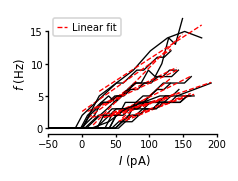

In [14]:
plt.figure(figsize=(2, 1.5))

first_fit = True
curves = plt.subplot(111)
for i, curve in enumerate(fi_summaries):
    if curve.is_monotonic:
        if first_fit:
            curve.plot(fitted_pltargs={'color': 'r', 'ls': '--', 'label': 'Linear fit'}, ax=curves, color='k')
            first_fit = False
        else:
            curve.plot(fitted_pltargs={'color': 'r', 'ls': '--'}, ax=curves, color='k')
    else:
        curve.plot(fitted=False, ax=curves, color='grey', alpha=0.8d)
    
curves.set_xlim(-50, curves.get_xlim()[1])

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only_unscaled.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only_unscaled.svg'))